In [5]:
import os, pickle, time
import numpy as np
import healpy as hp
from beamconv import ScanStrategy, tools
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
%matplotlib inline

We want to test the repeatibility of our satellite scan strategy with a simple script.

In [2]:
def get_cls(fname='../ancillary/wmap7_r0p03_lensed_uK_ext.txt'):
    cls = np.loadtxt(fname, unpack=True) # Cl in uK^2
    return cls[0], cls[1:]

In [3]:
nsamp       = 1000
nside_spin  = 512
lmax        = 1000
mmax        = 1
mlen        = 10
sample_rate = 100.0
nside_out   = 256
verbose     = 1
ctime0      = 1510000000

In [7]:
# Load up alm                                                                            
ell, cls = get_cls()
np.random.seed(42)
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK  

Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-1000


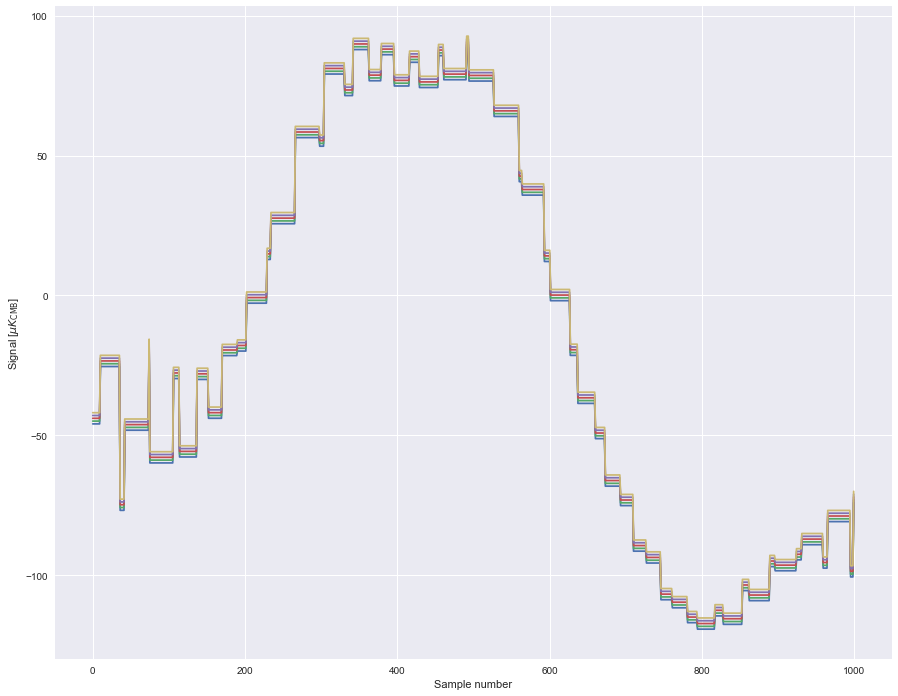

In [8]:
fig, ax1 = plt.subplots(figsize=8, 5))
for n in range(5):
        
    sat = ScanStrategy(mlen, external_pointing=True, sample_rate=sample_rate,
        location='space', ctime0=ctime0, nside_out=nside_out)

    #ss.load_focal_plane('.', no_pairs=True)
    sat.create_focal_plane(nrow=1, ncol=1, fov=0, 
        fwhm=30., lmax=lmax, mmax=mmax, amplitude=1.,
        no_pairs=True)
    
    scan_opts = dict(q_bore_func=sat.satellite_scan,
    ctime_func=sat.satellite_ctime,
    q_bore_kwargs=dict(jitter_amp=0.),
    ctime_kwargs=dict(),
    max_spin=mmax,
    nside_spin=nside_spin)

    sat.scan_instrument_mpi(alm, verbose=verbose, binning=False, **scan_opts)
    
    ax1.plot(sat.tod + n)
    
#ax1.legend()
ax1.set_ylabel(r'Signal [$\mu K_{\mathrm{CMB}}$]')
ax1.set_xlabel('Sample number')